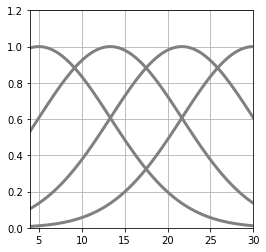

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

outfile = np.load('ch_data.npz')
X = outfile['X']
X_min = outfile['X_min']
X_max = outfile['X_max']
X_n = outfile['X_n']
T = outfile['T']

def gauss(x, mu, s):
    return np.exp(-(x-mu)**2 / (2*s**2))
    
M = 4
plt.figure(figsize=(4,4))
mu = np.linspace(5,30,M)
s = mu[1] - mu[0]
xb = np.linspace(X_min, X_max, 100)
for j in range(M):
    y = gauss(xb,mu[j],s)
    plt.plot(xb,y,color='gray',linewidth=3)
plt.grid(True)
plt.xlim(X_min,X_max)
plt.ylim(0,1.2)
plt.show()

W=[29.4 75.7  2.9 98.3 54.9]
SD =3.98 cm


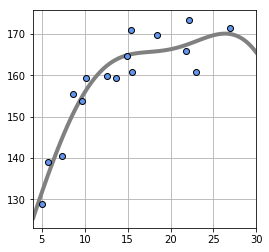

In [2]:
def gauss_func(w,x):
    m = len(w) - 1
    mu = np.linspace(5,30,m)
    s = mu[1] - mu[0]
    y = np.zeros_like(x)
    for j in range(m):
        y = y + w[j] * gauss(x,mu[j],s)
        
    y = y + w[m]
    return y

def mse_gauss_func(x,t,w):
    y = gauss_func(w,x)
    mse = np.mean((y-t)**2)
    return mse

def fit_gauss_func(x,t,m):
    mu = np.linspace(5,30,m)
    s = mu[1] - mu[0]
    n = x.shape[0]
    psi = np.ones((n, m+1))
    for j in range(m):
        psi[:,j] = gauss(x,mu[j],s)
    psi_T = np.transpose(psi)
    
    b = np.linalg.inv(psi_T.dot(psi))
    c = b.dot(psi_T)
    w = c.dot(t)
    return w

def show_gauss_func(w):
    xb = np.linspace(X_min, X_max, 100)
    y = gauss_func(w, xb)
    plt.plot(xb, y, c=[.5,.5,.5],lw=4)
    
plt.figure(figsize=(4,4))
M=4
W = fit_gauss_func(X,T,M)
show_gauss_func(W)
plt.plot(X,T,marker='o',linestyle='None',color='cornflowerblue',markeredgecolor='black')
plt.xlim(X_min,X_max)
plt.grid(True)
mse = mse_gauss_func(X,T,W)
print('W=' + str(np.round(W,1)))
print("SD ={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

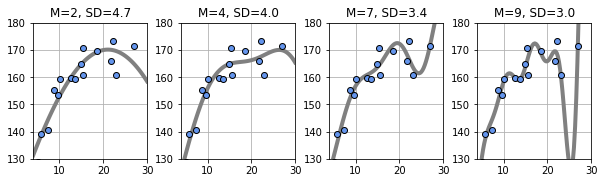

In [3]:
# オーバーフィッティングの問題
plt.figure(figsize=(10,2.5))
plt.subplots_adjust(wspace=0.3)
M = [2,4,7,9]
for i in range(len(M)):
    plt.subplot(1, len(M), i+1)
    W = fit_gauss_func(X,T,M[i])
    show_gauss_func(W)
    plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
    plt.xlim(X_min,X_max)
    plt.grid(True)
    plt.ylim(130,180)
    mse = mse_gauss_func(X,T,W)
    
    plt.title("M={0:d}, SD={1:.1f}".format(M[i], np.sqrt(mse)))

plt.show()

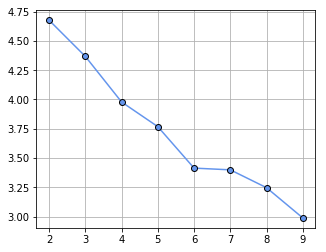

In [5]:
plt.figure(figsize=(5,4))
M = range(2,10)
mse2 = np.zeros(len(M))
for i in range(len(M)):
    W = fit_gauss_func(X,T,M[i])
    mse2[i] = np.sqrt(mse_gauss_func(X,T,W))
plt.plot(M, mse2, marker='o', color='cornflowerblue', markeredgecolor='black')
plt.grid(True)
plt.show()